# Learning Curve

## Objectifs:
 - Calculer l'AUC avec un Ensemble sur le VAL SET
 - Calculer l'AUC avec un Deepnet sur le VAL SET
 - Calculer l'AUC avec un Ensemble sur le TRAIN SET
 - Calculer l'AUC avec un Deepnet sur le TRAIN SET
 - Représenter les données dans trois graphiques :
  - Learning Curve (AUC / % Split) Ensemble vs Deepnet
  - Learning Curve (AUC / % Split) Ensemble : Training Error / Dev Error
  - Learning Curve (AUC / % Split) Deepnet : Training Error / Dev Error

In [1]:
# On importe la librairie bigml
from bigml.api import BigML
from os import path
import time
import pprint
from pickle import load, dump

In [2]:
# Configuration de pprint
pp = pprint.PrettyPrinter(indent=4)
# Configuration de pickle
jar_filename = 'storage/gmsc-picklejar'

In [3]:
# Connexion à BigML
api = BigML(project='project/5d94a32e42129f2e16000232')

In [4]:
# Fonction permettant d'ouvrir une jar avec pickle
def read_jar(jar_filename):
    if path.exists(jar_filename): # Si le fichier existe on l'ouvre
        with open(jar_filename, 'rb') as file:
            project_data = load(file)
    else: # Si le fichier n'existe pas un crée un dictionnaire vide
        project_data = {}
    return project_data

# Fonction permettant de sauvegarder des données dans une jar avec pickle
def save_jar(jar_filename, project_data):
    with open(jar_filename, 'wb') as file:
        dump(project_data,file)
    return project_data

In [21]:
# Learning Curves
project_data = read_jar(jar_filename)

 # On boucle sur l'axe des abscisses / Taille du dataset de train / % de ligne du dataset de train_train
for i in range(0,11):
    # Création du dictionnaire
    if i not in project_data:
        project_data[i] = {}
    ## Dataset
    if 'dataset' not in project_data[i]:
        project_data[i]['dataset'] = {}
    ## Modèles
    if 'models' not in project_data[i]:
        project_data[i]['models'] = {}
    if 'Ensemble' not in project_data[i]['models']:
        project_data[i]['models']['Ensemble'] = {}
    if 'Deepnet' not in project_data[i]['models']:
        project_data[i]['models']['Deepnet'] = {}
    ## Evaluations
    if 'evaluations' not in project_data[i]:
        project_data[i]['evaluations'] = {}
    ### Val set
    if 'val_set' not in project_data[i]['evaluations']:
        project_data[i]['evaluations']['val_set'] = {}
    if 'Ensemble' not in project_data[i]['evaluations']['val_set']:
        project_data[i]['evaluations']['val_set']['Ensemble'] = {}
    if 'Deepnet' not in project_data[i]['evaluations']['val_set']:
        project_data[i]['evaluations']['val_set']['Deepnet'] = {}
    ### Train set  
    if 'train_set' not in project_data[i]['evaluations']:
        project_data[i]['evaluations']['train_set'] = {}
    if 'Ensemble' not in project_data[i]['evaluations']['train_set']:
        project_data[i]['evaluations']['train_set']['Ensemble'] = {}
    if 'Deepnet' not in project_data[i]['evaluations']['train_set']:
        project_data[i]['evaluations']['train_set']['Deepnet'] = {}
        
    if i == 0 :
        # On crée une source à partir du fichier csv DATASET TRAIN FULL
        if 'source_train' not in project_data[0]:
            source_train = api.create_source('storage/source_dataset_train_full.csv')
            project_data[0]['source_train'] = source_train['resource']
        else:
            source_train = api.get_source(project_data[0]['source_train'])
        api.ok(source_train)
        print(f" >> Source TRAIN FULL : OK")
        save_jar(jar_filename, project_data)

        # On crée une source à partir du fichier csv DATASET TEST
        if 'source_test' not in project_data[0]:
            source_test = api.create_source('storage/source_dataset_test.csv')
            project_data[0]['source_test'] = source_test['resource']
        else:
            source_test = api.get_source(project_data[0]['source_test'])
        api.ok(source_test)
        print(f" >> Source TEST : OK")
        save_jar(jar_filename, project_data)

        # On crére le dataset TRAIN FULL à partir de la source
        if 'dataset_train_full' not in project_data[0]:
            dataset_train_full = api.create_dataset(source_train, {"name": "Dataset Train Full"})
            project_data[0]['dataset_train_full'] = dataset_train_full['resource']
        else:
            dataset_train_full = api.get_dataset(project_data[0]['dataset_train_full'])
        api.ok(dataset_train_full)
        print(f" >>> Dataset TRAIN FULL : OK")
        save_jar(jar_filename, project_data)

        # On crére le dataset TRAIN TRAIN à partir de la source
        if 'dataset_train_train' not in project_data[0]:
            dataset_train_train = api.create_dataset(dataset_train_full, {"name": "Dataset Train Train", "sample_rate": 0.8, "seed": "my seed"})
            project_data[0]['dataset_train_train'] = dataset_train_train['resource']
        else:
            dataset_train_train = api.get_dataset(project_data[0]['dataset_train_train'])
        api.ok(dataset_train_train)
        print(f" >>> Dataset TRAIN TRAIN : OK")
        save_jar(jar_filename, project_data)

        # On crére le dataset TRAIN TEST à partir de la source
        if 'dataset_train_test' not in project_data[0]:
            dataset_train_test = api.create_dataset(dataset_train_full, {"name": "Dataset Train Test", "sample_rate": 0.8 , "seed": "my seed", "out_of_bag": True})
            project_data[0]['dataset_train_test'] = dataset_train_train['resource']
        else:
            dataset_train_test = api.get_dataset(project_data[0]['dataset_train_test'])
        api.ok(dataset_train_test)
        print(f" >>> Dataset TRAIN TEST : OK")
        save_jar(jar_filename, project_data)

        # On crée le dataset TEST à partir de la source
        if 'dataset_test' not in project_data[0]:
            dataset_test = api.create_dataset(source_test, {"name": "Dataset Test"})
            project_data[0]['dataset_test'] = dataset_test['resource']
        else:
            dataset_test = api.get_dataset(project_data[0]['dataset_test'])
        api.ok(dataset_test)
        print(f" >>> Dataset TEST : OK")
        save_jar(jar_filename, project_data)
   
    else:
        # Dataset 
        ## Création ou charement des dataset
        if 'dataset_id' not in project_data[i]['dataset']: # Le dataset n'existe pas, on le crée
            # On crée le nouveau dataset de train à partir du dataset de train initial
            dataset_train_train_split = api.create_dataset(dataset_train_train, {"name": "Dataset Train Train " + str(i/10), "sample_rate": i/10, "seed": "my seed"})
            project_data[i]['dataset']['dataset_id'] = dataset_train_train_split['resource']
        else: # Le dataset existe, on le charge
            # On récupère le dataset de train
            dataset_train_train_split = api.get_dataset(project_data[i]['dataset']['dataset_id'])
        api.ok(dataset_train_train_split)
        save_jar(jar_filename, project_data)

        # Modèles
        ## Création ou chargement des Ensemble
        if 'model_id' not in project_data[i]['models']['Ensemble']:
            ensemble = api.create_ensemble(dataset_train_train_split, {"objective_field" : "SeriousDlqin2yrs", "name": "Ensemble " + str(i/10)})
            project_data[i]['models']['Ensemble']['model_id'] = ensemble['resource']
        else:
            ensemble = api.get_ensemble(project_data[i]['models']['Ensemble']['model_id'])
        api.ok(ensemble) 
        save_jar(jar_filename, project_data)

        ## Création ou chargement des Deepnet
        if 'model_id' not in project_data[i]['models']['Deepnet']:
            deepnet = api.create_deepnet(dataset_train_train_split, {"objective_field" : "SeriousDlqin2yrs", "name": "Deepnet " + str(i/10)})
            project_data[i]['models']['Deepnet']['model_id'] = deepnet['resource']
        else:
            deepnet = api.get_deepnet(project_data[i]['models']['Deepnet']['model_id'])
        api.ok(deepnet)
        save_jar(jar_filename, project_data)

        # Evaluations
        ## VAL SET
        ### Ensemble
        if 'evaluation_id' not in project_data[i]['evaluations']['val_set']['Ensemble']:
            evaluation_valset_ensemble = api.create_evaluation(ensemble, dataset_train_test)
            api.ok(evaluation_valset_ensemble)
            project_data[i]['evaluations']['val_set']['Ensemble']['evaluation_id'] = evaluation_valset_ensemble['resource']
            project_data[i]['evaluations']['val_set']['Ensemble']['auc'] = evaluation_valset_ensemble['object']['result']['model']['average_area_under_roc_curve']
        else:
            evaluation_valset_ensemble = api.get_evaluation(project_data[i]['evaluations']['val_set']['Ensemble']['evaluation_id'])
            api.ok(evaluation_valset_ensemble)
            project_data[i]['evaluations']['val_set']['Ensemble']['auc'] = evaluation_valset_ensemble['object']['result']['model']['average_area_under_roc_curve']
        save_jar(jar_filename, project_data)
        ### Deepnet
        if 'evaluation_id' not in project_data[i]['evaluations']['val_set']['Deepnet']:
            evaluation_valset_deepnet = api.create_evaluation(deepnet, dataset_train_test)
            api.ok(evaluation_valset_deepnet)
            project_data[i]['evaluations']['val_set']['Deepnet']['evaluation_id'] = evaluation_valset_deepnet['resource']
            project_data[i]['evaluations']['val_set']['Deepnet']['auc'] = evaluation_valset_deepnet['object']['result']['model']['average_area_under_roc_curve']
        else:
            evaluation_valset_deepnet = api.get_evaluation(project_data[i]['evaluations']['val_set']['Deepnet']['evaluation_id'])
            api.ok(evaluation_valset_deepnet)
            project_data[i]['evaluations']['val_set']['Deepnet']['auc'] = evaluation_valset_deepnet['object']['result']['model']['average_area_under_roc_curve']
        save_jar(jar_filename, project_data)
        ## TRAIN SET
        ### Ensemble
        if 'evaluation_id' not in project_data[i]['evaluations']['train_set']['Ensemble']:
            evaluation_trainset_ensemble = api.create_evaluation(ensemble, dataset_train_train_split)
            api.ok(evaluation_trainset_ensemble)
            project_data[i]['evaluations']['train_set']['Ensemble']['evaluation_id'] = evaluation_trainset_ensemble['resource']
            project_data[i]['evaluations']['train_set']['Ensemble']['auc'] = evaluation_trainset_ensemble['object']['result']['model']['average_area_under_roc_curve']
        else:
            evaluation_trainset_ensemble = api.get_evaluation(project_data[i]['evaluations']['train_set']['Ensemble']['evaluation_id'])
            api.ok(evaluation_trainset_ensemble)
            project_data[i]['evaluations']['train_set']['Ensemble']['auc'] = evaluation_trainset_ensemble['object']['result']['model']['average_area_under_roc_curve']
        save_jar(jar_filename, project_data)
        ### Deepnet
        if 'evaluation_id' not in project_data[i]['evaluations']['train_set']['Deepnet']:
            evaluation_trainset_deepnet = api.create_evaluation(deepnet, dataset_train_train_split)
            api.ok(evaluation_trainset_deepnet)
            project_data[i]['evaluations']['train_set']['Deepnet']['evaluation_id'] = evaluation_trainset_deepnet['resource']
            project_data[i]['evaluations']['train_set']['Deepnet']['auc'] = evaluation_trainset_deepnet['object']['result']['model']['average_area_under_roc_curve']
        else:
            evaluation_trainset_deepnet = api.get_evaluation(project_data[i]['evaluations']['train_set']['Deepnet']['evaluation_id'])
            api.ok(evaluation_trainset_deepnet)
            project_data[i]['evaluations']['train_set']['Deepnet']['auc'] = evaluation_trainset_deepnet['object']['result']['model']['average_area_under_roc_curve']
        save_jar(jar_filename, project_data)
        
        print(f" >>>> Evaluation {i} : OK")
    i += 1

# On enregistre le dictionnaire project_data dans un fichier via la fonction dump
save_jar(jar_filename, project_data)

print(' >>>>> Terminé')

 >> Source TRAIN FULL : OK
 >> Source TEST : OK
 >>> Dataset TRAIN FULL : OK
 >>> Dataset TRAIN TRAIN : OK
 >>> Dataset TRAIN TEST : OK
 >>> Dataset TEST : OK
 >>>> Evaluation 1 : OK
 >>>> Evaluation 2 : OK
 >>>> Evaluation 3 : OK
 >>>> Evaluation 4 : OK
 >>>> Evaluation 5 : OK
 >>>> Evaluation 6 : OK
 >>>> Evaluation 7 : OK
 >>>> Evaluation 8 : OK
 >>>> Evaluation 9 : OK
 >>>> Evaluation 10 : OK
 >>>>> Terminé


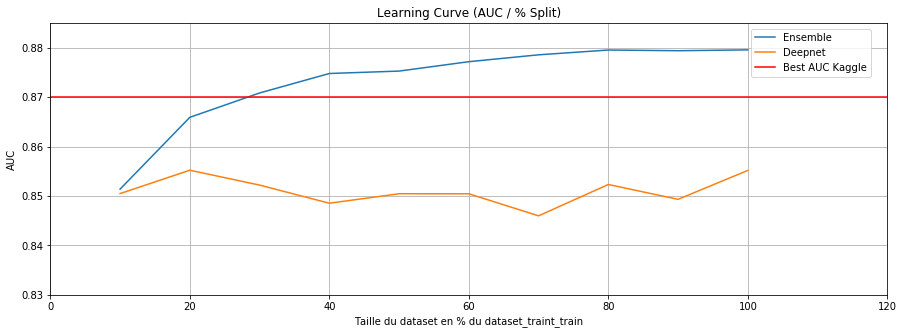

AUC VAL SET Ensemble : [0.8514, 0.86593, 0.87086, 0.8748, 0.87529, 0.87719, 0.87858, 0.87955, 0.87941, 0.87958]
AUC VAL SET Deepnet : [0.8505, 0.85523, 0.85222, 0.84855, 0.85047, 0.85046, 0.846, 0.85234, 0.84934, 0.85519]


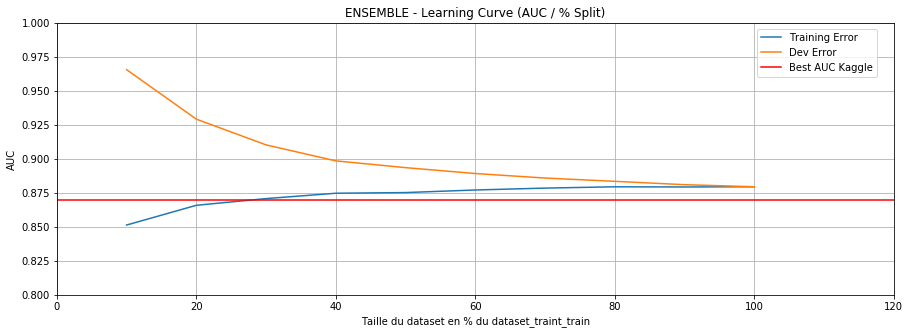

AUC VAL SET Ensemble : [0.8514, 0.86593, 0.87086, 0.8748, 0.87529, 0.87719, 0.87858, 0.87955, 0.87941, 0.87958]
AUC TRAIN SET Ensemble : [0.96576, 0.92933, 0.91038, 0.89862, 0.89363, 0.88931, 0.88598, 0.88357, 0.88109, 0.87958]


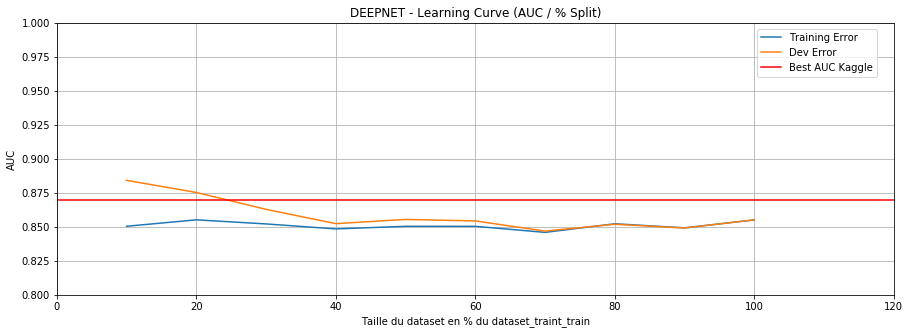

AUC VAL SET Deepnet : [0.8505, 0.85523, 0.85222, 0.84855, 0.85047, 0.85046, 0.846, 0.85234, 0.84934, 0.85519]
AUC TRAIN SET Deepnet : [0.88429, 0.87537, 0.86295, 0.85242, 0.85554, 0.85443, 0.84697, 0.85196, 0.84921, 0.85519]


In [44]:
# On ouvre le fichier contenant les datas du projet, notamment les AUC
project_data = read_jar(jar_filename)
    
# On initialise les listes graph_x et graph_y
graph_x = []
graph_y_valset_ensemble = []
graph_y_valset_deepnet = []
graph_y_trainset_ensemble = []
graph_y_trainset_deepnet = []

# On complète les listes depuis les datas du projet
i = 0
for project_data_auc in project_data.values():
    if i != 0: # On saute la première boucle car elle contient les informations sur les sources et les dataset de base
        graph_x.append(i)
        graph_y_valset_ensemble.append(project_data_auc['evaluations']['val_set']['Ensemble']['auc'])
        graph_y_valset_deepnet.append(project_data_auc['evaluations']['val_set']['Deepnet']['auc'])
        graph_y_trainset_ensemble.append(project_data_auc['evaluations']['train_set']['Ensemble']['auc'])
        graph_y_trainset_deepnet.append(project_data_auc['evaluations']['train_set']['Deepnet']['auc'])
    i += 10


# On génère le graphique Learning Curve (AUC / % Split)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(graph_x, graph_y_valset_ensemble, label='Ensemble')
ax.plot(graph_x, graph_y_valset_deepnet, label='Deepnet')
ax.axhline(y=0.87, color='r', label='Best AUC Kaggle')
ax.set(xlim=(0, 120), ylim=(0.83, 0.885), xlabel='Taille du dataset en % du dataset_traint_train', ylabel='AUC',  title='Learning Curve (AUC / % Split)')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='best', borderaxespad=0.)
ax.grid()
plt.show()
print(f"AUC VAL SET Ensemble : {graph_y_valset_ensemble}")
print(f"AUC VAL SET Deepnet : {graph_y_valset_deepnet}")

# On génère le graphique ENSEMBLE - Learning Curve (AUC / % Split)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(graph_x, graph_y_valset_ensemble, label='Training Error')
ax.plot(graph_x, graph_y_trainset_ensemble, label='Dev Error')
ax.axhline(y=0.87, color='r', label='Best AUC Kaggle')
ax.set(xlim=(0, 120), ylim=(0.8, 1), xlabel='Taille du dataset en % du dataset_traint_train', ylabel='AUC',  title='ENSEMBLE - Learning Curve (AUC / % Split)')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='best', borderaxespad=0.)
ax.grid()
plt.show()

print(f"AUC VAL SET Ensemble : {graph_y_valset_ensemble}")
print(f"AUC TRAIN SET Ensemble : {graph_y_trainset_ensemble}")

# On génère le graphique DEEPNET - Learning Curve (AUC / % Split)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(graph_x, graph_y_valset_deepnet, label='Training Error')
ax.plot(graph_x, graph_y_trainset_deepnet, label='Dev Error')
ax.axhline(y=0.87, color='r', label='Best AUC Kaggle')
ax.set(xlim=(0, 120), ylim=(0.8, 1), xlabel='Taille du dataset en % du dataset_traint_train', ylabel='AUC',  title='DEEPNET - Learning Curve (AUC / % Split)')
plt.legend(bbox_to_anchor=(0.98, 0.98), loc='best', borderaxespad=0.)
ax.grid()
plt.show()

print(f"AUC VAL SET Deepnet : {graph_y_valset_deepnet}")
print(f"AUC TRAIN SET Deepnet : {graph_y_trainset_deepnet}")